<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/13-transfer-learning/02_transfer_learning_with_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transfer learning with Text

The idea behind transfer learning is
that if someone has gone through the effort of training a big model on a bunch of data,
you can probably use that already trained model as a starting point for your problem.

Transfer learning works best when there are intrinsic similarities between the original
larger set of data and the smaller target data you want to apply it to.

Essentially, we want to transfer things we have learned
about one domain to a different, but related, domain. This is the idea behind transfer
learning.



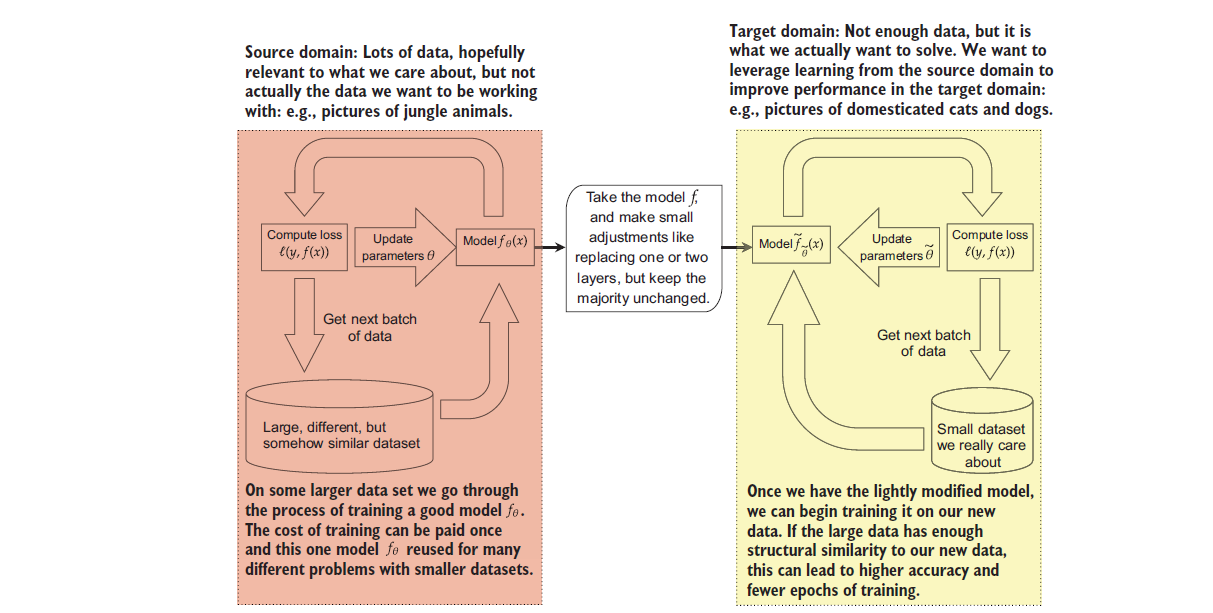

One of the most successful approaches to transfer learning that we learn to transfer the weights $w_{\theta}$ from one model to another. The original model is
trained on a large dataset of high-quality data, which shares some structural similarities
with the smaller set of data that we really care about.

The success of using pretrained networks to perform transfer learning depends on learning robust features/patterns that are widely applicable.

Until recently, this approach had not been successful for natural language processing (NLP) related tasks. Thanks to new models like the transformer, this situation is finally starting to change.

In particular, a family of transformer-based algorithms has significantly improved the quality of results we can achieve on text problems. The first of these pretrained models is called BERT.

To get started adjusting a pretrained BERT model, we will reuse the AG News dataset.

##Setup

In [ ]:
!pip install portalocker
!pip install transformers
!pip install sentencepiece

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab

from torchtext.datasets import AG_NEWS

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

from idlmam import set_seed

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import LastTimeStep, train_network, Flatten, weight_reset, View, LambdaLayer
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore, getMaskByFill

import os
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [ ]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

In [ ]:
!mkdir -p data

##AG News dataset

In [ ]:
# let’s quickly load AG_NEWS dataset
train_iter, test_iter = AG_NEWS(root="./data", split=("train", "test"))

train_dataset = list(train_iter)
test_dataset = list(test_iter)

In [ ]:
print(train_dataset[0])

In [ ]:
# tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']
tokenizer = get_tokenizer("basic_english") # we will be fine with the default english style tokenizer

# we need to create a vocabulary of all the words in the training set
counter = Counter()
for (label, line) in train_dataset:
  # count the number of unique tokens we see and how often we see them (e.g., we will see "the" a lot, but "sasquatch" maybe once or not at all.)
  counter.update(tokenizer(line))
# create a vocab object, removing any word that didn't occur at least 10 times,
# and add special vocab items for unkown, begining of sentance, end of sentance, and "padding"
vocab = vocab(counter, min_freq=10, specials=("<unk>", "<BOS>", "<EOS>", "<PAD>"))
vocab.set_default_index(vocab["<unk>"])

In [ ]:
len(vocab)

In [ ]:
def text_transform(x):
  # vocab acts like a dictionary, handls unkown tokens.
  # We can make it pre- and post-pend with the start and end markers, respectively.
  return [vocab["<BOS>"]] + [vocab[token] for token in tokenizer(x)] + [vocab["<EOS>"]]

def label_transform(y):
  # labes are originally [1, 2, 3, 4] but we need them as [0, 1, 2, 3]
  return y - 1

In [ ]:
train_dataset[0][1]

In [ ]:
# let's transform the first data point's text into a list of tokens
print(text_transform(train_dataset[0][1]))

In [ ]:
# To make training faster, let’s limit ourselves to sentences that contain six or fewer words.
VOCAB_SIZE  = len(vocab)
NUM_CLASS = len(np.unique([z[0] for z in train_dataset]))
print(f"Vocab: {VOCAB_SIZE}")
print(f"Num Classes: {NUM_CLASS}")

padding_idx = VOCAB_SIZE
VOCAB_SIZE += 1

##Pretrained model

By default, the ResNet model has
random weights, so this is basically giving us a new ResNet to train from scratch for our
problem.

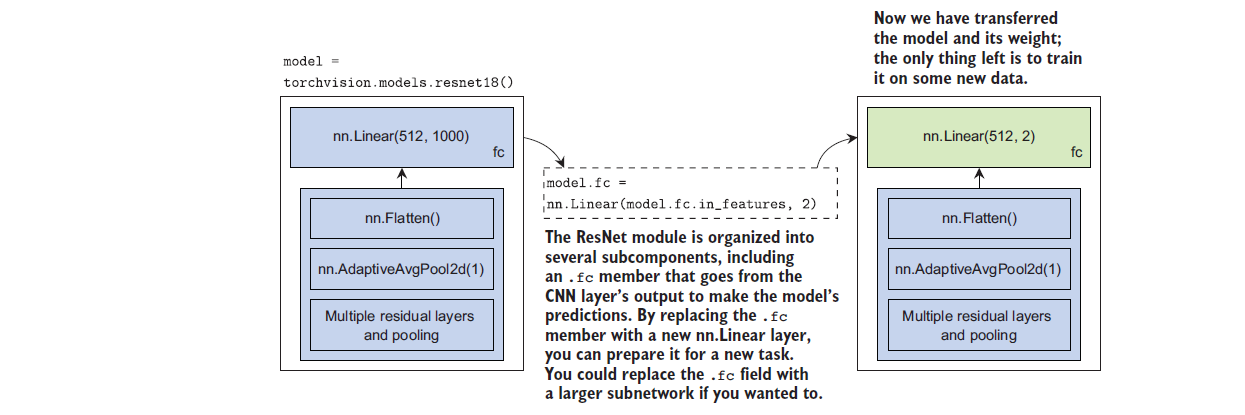

In [ ]:
model = torchvision.models.resnet18()

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
# We are going to perfrom some "surgery"
model.fc = nn.Linear(model.fc.in_features, 2)
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
loss = nn.CrossEntropyLoss()

Now, we can train this model to predict whether an image is of a cat or a dog.

In [ ]:
normal_results = train_network(model,
                              loss,
                              train_loader,
                              val_loader=test_loader,
                              score_funcs={'Accuracy': accuracy_score},
                              device=device, epochs=10)

<Axes: xlabel='epoch', ylabel='val Accuracy'>

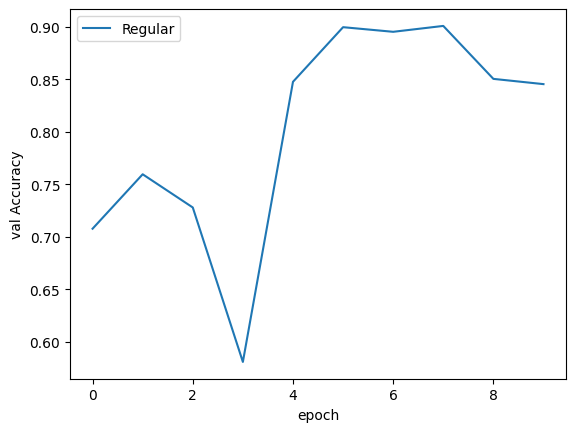

In [ ]:
sns.lineplot(x="epoch", y="val Accuracy", data=normal_results, label="Regular")

##Adjusting pretrained model

We may have to learn this `nn.Linear` layer from scratch, but all the preceding
convolutional layers should be at a better starting place because they were trained on
so much data.

In [ ]:
# a model that has already been trained on some dataset
model_pretrained = torchvision.models.resnet18(pretrained=True)
# We are going to perfrom some "surgery"
model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, 2)

In [ ]:
# let's grab the first convolutional filters weights, moving them to CPU, and turns them into a NumPy tensor
filters_pretrained = model_pretrained.conv1.weight.data.cpu().numpy()
filters_pretrained.shape

(64, 3, 7, 7)

In [ ]:
# let’s first normalize the filters to the range [0; 1] for plotting
filters_pretrained = filters_pretrained - np.min(filters_pretrained)   # shift so everything is in the range [0, Max value]
filters_pretrained = filters_pretrained / np.max(filters_pretrained)   # Re-scale so everything is [0, 1]

# The weights are shaped as (#Filters, C, W, H) but matplotlib expects (W, H, C), so we will move the channel dimension
filters_pretrained = np.moveaxis(filters_pretrained, 1, -1)

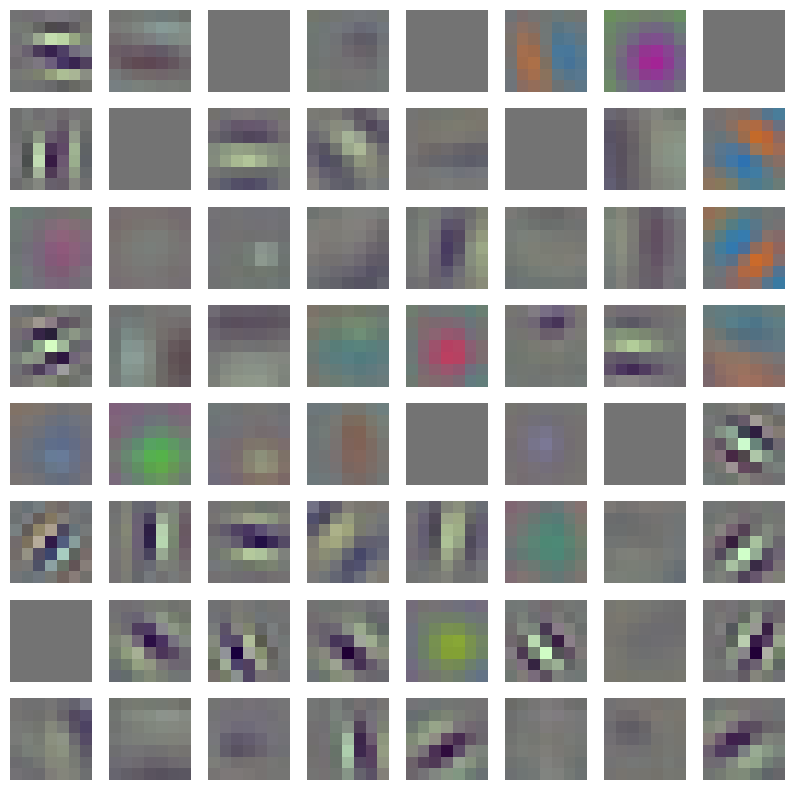

In [ ]:
# Now, we can plot the filters
i_max = int(round(np.sqrt(filters_pretrained.shape[0])))          #take sqrt(# items) to make a square grid of images
j_max = int(np.floor(filters_pretrained.shape[0] / float(i_max))) #divide by # of rows
f, axarr = plt.subplots(i_max,j_max, figsize=(10,10))             # make the grid to plot the images in
for i in range(i_max):    #each row
  for j in range(j_max):  #each column
    indx = i*j_max+j      #index into the filters
    axarr[i,j].imshow(filters_pretrained[indx,:]) #plot the specific filter
    axarr[i,j].set_axis_off()                     # turn off the numbered axis to avoid clutter

In [ ]:
def visualize_filters(conv_filters):
  conv_filters = conv_filters - np.min(conv_filters)   # shift so everything is in the range [0, Max value]
  conv_filters = conv_filters / np.max(conv_filters)   # Re-scale so everything is [0, 1]

  # The weights are shaped as (#Filters, C, W, H) but matplotlib expects (W, H, C), so we will move the channel dimension
  conv_filters = np.moveaxis(conv_filters, 1, -1)

  i_max = int(round(np.sqrt(conv_filters.shape[0])))          #take sqrt(# items) to make a square grid of images
  j_max = int(np.floor(conv_filters.shape[0] / float(i_max))) #divide by # of rows
  f, axarr = plt.subplots(i_max,j_max, figsize=(10,10))       # make the grid to plot the images in
  for i in range(i_max):    #each row
    for j in range(j_max):  #each column
      indx = i*j_max+j      #index into the filters
      axarr[i,j].imshow(conv_filters[indx,:])  #plot the specific filter
      axarr[i,j].set_axis_off()                # turn off the numbered axis to avoid clutter

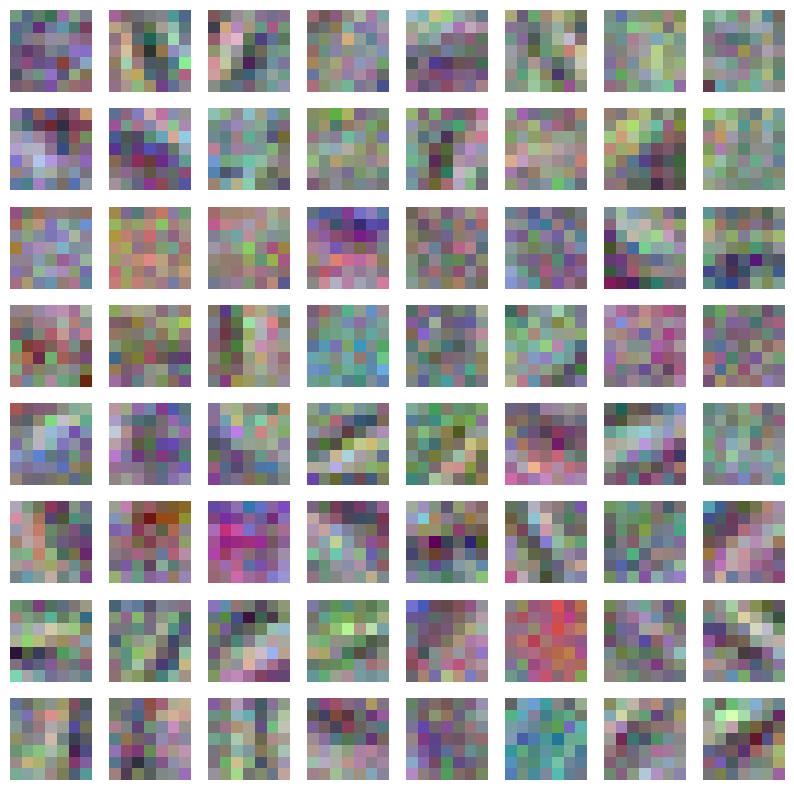

In [ ]:
# let's see filters from the model we trained at the start
filters_catdog = model.conv1.weight.data.cpu().numpy()
visualize_filters(filters_catdog)

##Preprocessing for pretrained model

If you use transfer learning via a pretrained network, you must make
sure your preprocessing of the data matches how the model was originally trained.

Otherwise, the model will not get what it initially expects, and the weights become
meaningless.

In [ ]:
class NormalizeInput(nn.Module):
  def __init__(self, base_model):
    """
    base_model: the original ResNet model that needs to have it's inputs pre-processed
    """
    super(NormalizeInput, self).__init__()

    # The model that we want to use, but need’s its input normalized first
    self.base_model = base_model

    # The mean and standard deviation used for ImageNet normalization. We just have to accept these “magic” numbers that everyone uses
    self.mean = nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1), requires_grad=False)
    self.std = nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1), requires_grad=False)

  def forward(self, X):
    # Normalize the input, then feed it into the model we want to use
    X = (X - self.mean) / self.std
    return self.base_model(X)

In [ ]:
# let's wraps the pretrained model with this specific normalizer
model_pretrained = NormalizeInput(model_pretrained)

##Training with warm starts

Let's trains this model, and we can
check the results and see how it did.This approach to transfer learning is called a warm start:

In [ ]:
warmstart_results = train_network(model_pretrained,
                                  loss,
                                  train_loader,
                                  val_loader=test_loader,
                                  score_funcs={'Accuracy': accuracy_score},
                                  device=device, epochs=10)

<Axes: xlabel='epoch', ylabel='val Accuracy'>

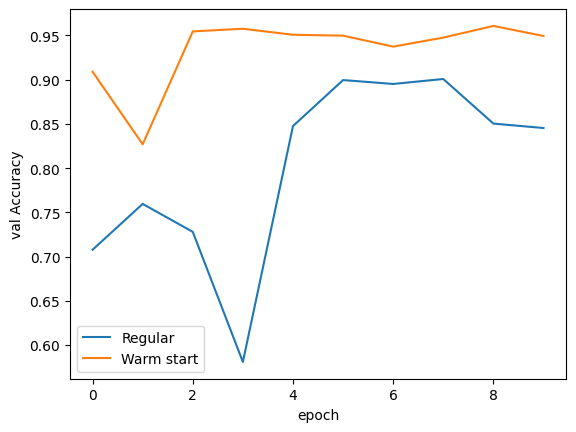

In [ ]:
sns.lineplot(x="epoch", y="val Accuracy", data=normal_results, label="Regular")
sns.lineplot(x="epoch", y="val Accuracy", data=warmstart_results, label="Warm start")

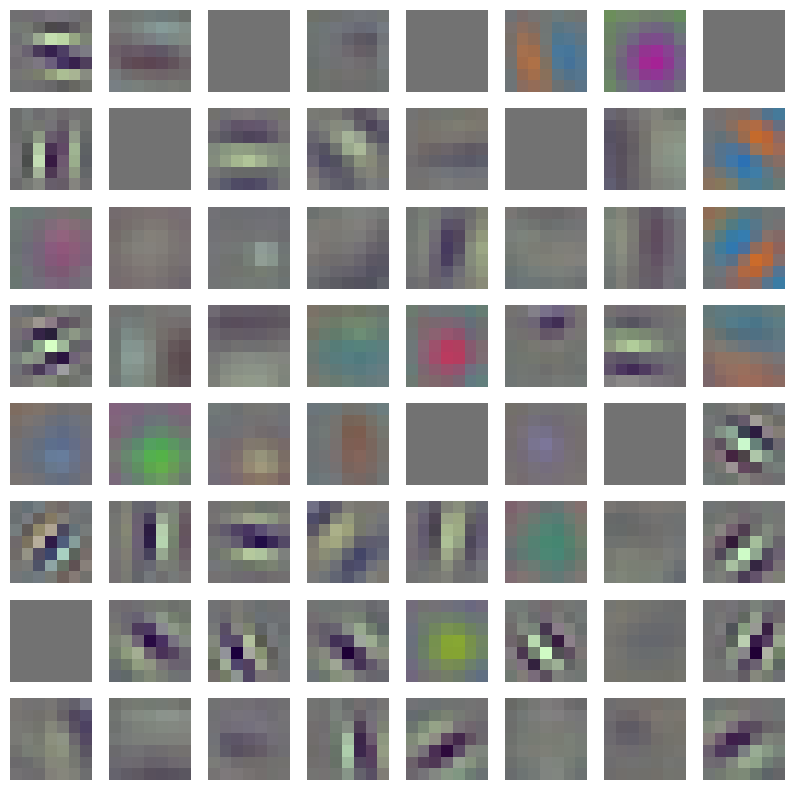

In [ ]:
# let's grab the filters after fine-tuning the warm-started model
filters_catdog_finetuned = model_pretrained.base_model.conv1.weight.data.cpu().numpy()
# let's plot the filters, which will look very similar to the pre-trained model's initial filters
visualize_filters(filters_catdog_finetuned)

##Training with frozen weights

Weight freezing is when we decide not to alter the parameters/
coefficients of a layer.

Training is only meaningful if we adjust at least some of
the parameters of the model. A common approach is to freeze the weights for all the convolutional and normalizing layers and only change the weights of the fully connected layers.

This implicitly assumes that the filters learned from the original domain are as good as or better than what we could learn on this new domain.

In [ ]:
# let's do the freezing process and then trains the model
model_frozen = torchvision.models.resnet18(pretrained=True)

# First, turn off gradient updating for all parameters!
for param in model_frozen.parameters():
  param.requires_grad = False

# Our new FC layer has requires_grad = True by default!
model_frozen.fc = nn.Linear(model_frozen.fc.in_features, 2)
model_frozen = NormalizeInput(model_frozen)

In [ ]:
frozen_transfer_results = train_network(model_frozen,
                                        loss,
                                        train_loader,
                                        val_loader=test_loader,
                                        score_funcs={'Accuracy': accuracy_score},
                                        device=device, epochs=10)

<Axes: xlabel='epoch', ylabel='val Accuracy'>

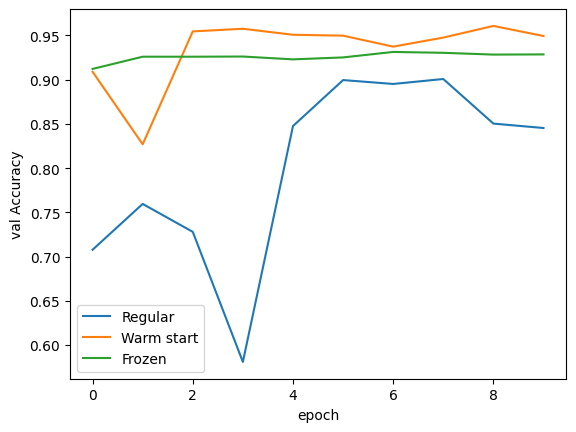

In [ ]:
sns.lineplot(x="epoch", y="val Accuracy", data=normal_results, label="Regular")
sns.lineplot(x="epoch", y="val Accuracy", data=warmstart_results, label="Warm start")
sns.lineplot(x="epoch", y="val Accuracy", data=frozen_transfer_results, label="Frozen")

##Learning with fewer labels

The frozen weights have a particular advantage when you have
extremely small amounts of training data.

One simplified way to think about
this is that your estimate of the true parameters is a noisy view of them:

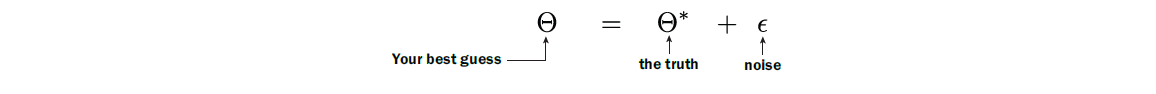

The more data you have, the better the model you can build, and $\epsilon \to 0$.

If you have no data, you can only pick answers randomly because you can only pick $𝝝$ randomly, so $\epsilon \to \infty$.

Clearly, the size of your training data $N$ impacts how well you can estimate your parameters.

When we freeze weights, they are no longer parameters we can modify, which effectively reduces the $D$ term of the equation and better estimates the remaining parameters.

This is also why the frozen approach is more stable than the warm approach: the noise factor is dampened by reducing the number of parameters $D$.

Let's simulate the situation with our cats versus dogs classifier by randomly sampling a small portion to use for training: twice our batch size, for a total of 256 training images.

This is normally far too little data to learn any kind of CNN from scratch

In [ ]:
# let's make the small dataset = 2* the batch size
train_data_small, _ = torch.utils.data.random_split(train_data, (B * 2, len(train_data) - B * 2))
# let's make the loader for this tiny dataset
train_loader_small = DataLoader(train_data_small, batch_size=B, shuffle=True)

Now we have a much smaller dataset. We can train a model using all three approaches:

* from scratch,
* using a warm start and,
* using frozen weights

If our understanding is correct,
freezing the weights should do better than a warm start in this scenario.

In [ ]:
#1) Training from scratch
model = torchvision.models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 2)
normal_small_results = train_network(model,
                              loss,
                              train_loader_small,
                              val_loader=test_loader,
                              score_funcs={'Accuracy': accuracy_score},
                              device=device, epochs=10)

In [ ]:
#2) Now lets train the warm model
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
# We are going to perfrom some "surgery"
model = NormalizeInput(model)
warmstart_small_results = train_network(model,
                              loss,
                              train_loader_small,
                              val_loader=test_loader,
                              score_funcs={'Accuracy': accuracy_score},
                              device=device, epochs=10)

In [ ]:
#3) Training with frozen weights
model = torchvision.models.resnet18(pretrained=True)
# First, turn off gradient updating for all parameters!
for param in model.parameters():
  param.requires_grad = False
# Our new FC layer has requires_grad = True by default!
model.fc = nn.Linear(model.fc.in_features, 2)
model = NormalizeInput(model)
frozen_transfer_small_results = train_network(model,
                              loss,
                              train_loader_small,
                              val_loader=test_loader,
                              score_funcs={'Accuracy': accuracy_score},
                              device=device, epochs=10)

<Axes: xlabel='epoch', ylabel='val Accuracy'>

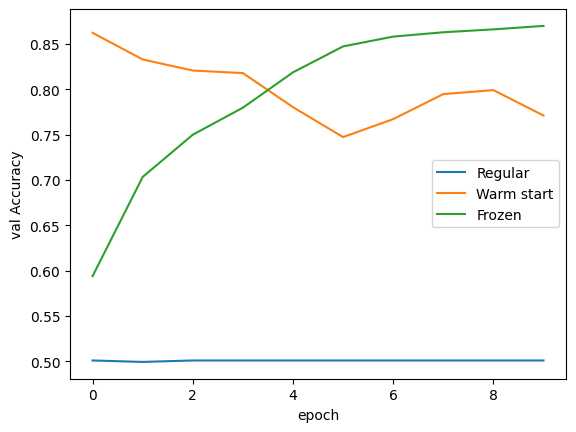

In [ ]:
sns.lineplot(x="epoch", y="val Accuracy", data=normal_small_results, label="Regular")
sns.lineplot(x="epoch", y="val Accuracy", data=warmstart_small_results, label="Warm start")
sns.lineplot(x="epoch", y="val Accuracy", data=frozen_transfer_small_results, label="Frozen")

We see a dramatic difference in the results.

- Training from scratch is still the worst
- Using a warm start is better
- using frozen convolutional layers does best

So the frozen approach is the best when we have
a very limited amount of training data, but its ability for further improvement is also limited.

That is where warm starts come in; warm models can start coming out ahead of
frozen models if you have enough labeled data (but still not too terribly much).